<a href="https://colab.research.google.com/github/sayam47/Mellowmax-RL/blob/master/Taxi_Mellow_vs_Boltzmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import deque
from collections import defaultdict
import gym
import sys
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [0]:
averages_history=[]

In [0]:
def interact(env, agent, num_episodes=10000, window=100):
    avg_rewards = deque(maxlen=num_episodes)
    best_avg_reward = -math.inf
    samp_rewards = deque(maxlen=window)
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        samp_reward = 0
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            samp_reward += reward
            state = next_state
            if done:
                samp_rewards.append(samp_reward)
                break
        avg_reward=0
        if (i_episode >= 100):
            avg_reward = np.mean(samp_rewards)
            avg_rewards.append(avg_reward)
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        averages_history.append(avg_reward)
        if i_episode%10==0:
            print("\rEpisode {}/{} || Average reward {} || Best average reward {}".format(i_episode, num_episodes,avg_reward , best_avg_reward), end="")
            sys.stdout.flush()
        if best_avg_reward >= 9.7:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
#             return i_episode
            break
        if i_episode == num_episodes: print('\n')
#     return 100000
    return avg_rewards, best_avg_reward

In [0]:
from scipy.optimize import brentq

class Agent:

    def __init__(self, nA=6,omega=25,beta=1,mellow=0):
        self.mellow=mellow
        self.beta=beta
        self.nA = nA
        self.omega=omega
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.gamma = 0.9
        self.alpha = 0.1
        
    def mellowmax(self,beta,state):
        c=np.max(self.Q[state])
        mellow=c+np.log(np.sum(np.exp(self.omega*(self.Q[state]-c)))/self.nA)/self.omega
        ans=np.sum(np.exp((self.Q[state]-mellow)*beta)*(self.Q[state]-mellow))
        return ans

    def get_action_probability(self, state):
        if self.mellow==1:
            beta=brentq(self.mellowmax,-500,500,args=(state,))
        else:
            beta=self.beta
        policy_s = np.exp(beta*self.Q[state])/np.sum(np.exp(beta*self.Q[state]))
        return policy_s

    def select_action(self, state):
        policy_s = self.get_action_probability(state)
        return np.random.choice(np.arange(self.nA), p=policy_s)
    
    def step(self, state, action, reward, next_state, done):
        next_action_value = self.Q[next_state][self.select_action(next_state)]
        self.Q[state][action] += self.alpha * (reward  + self.gamma * next_action_value - self.Q[state][action])

In [0]:
env = gym.make('Taxi-v2')

In [0]:
its=1

In [0]:
x_best=[]
for i in range(10,21):
    b=0
    for j in range(its):
        averages_history=[]
        agent = Agent(beta=i)
        agent.init_for_sarsa()
        avg_rewards,best_avg_rewards =interact(env,agent)
        b+=best_avg_rewards
    b/=its
    x_best.append(b)

Episode 10000/10000 || Average reward 8.69 || Best average reward 9.14

Episode 10000/10000 || Average reward 8.62 || Best average reward 9.1

Episode 10000/10000 || Average reward 8.09 || Best average reward 9.34

Episode 10000/10000 || Average reward 8.62 || Best average reward 9.22

Episode 10000/10000 || Average reward 8.31 || Best average reward 9.02

Episode 10000/10000 || Average reward 8.52 || Best average reward 9.17

Episode 10000/10000 || Average reward 8.42 || Best average reward 9.12

Episode 10000/10000 || Average reward 8.53 || Best average reward 9.01

Episode 10000/10000 || Average reward 8.41 || Best average reward 9.05

Episode 10000/10000 || Average reward 8.36 || Best average reward 9.26

Episode 10000/10000 || Average reward 8.6 || Best average reward 9.29



In [0]:
y_best=[]
for i in range(10,21):
    b=0
    for j in range(its):
        averages_history=[]
        agent = Agent(omega=i,mellow=1)
        agent.init_for_sarsa()
        avg_rewards,best_avg_rewards =interact(env,agent)
        b+=best_avg_rewards
    b/=its
    y_best.append(b)

Episode 10000/10000 || Average reward 7.25 || Best average reward 8.35

Episode 10000/10000 || Average reward 7.83 || Best average reward 8.66

Episode 10000/10000 || Average reward 8.14 || Best average reward 8.79

Episode 10000/10000 || Average reward 7.51 || Best average reward 8.86

Episode 10000/10000 || Average reward 7.82 || Best average reward 8.57

Episode 10000/10000 || Average reward 7.61 || Best average reward 8.8

Episode 10000/10000 || Average reward 7.69 || Best average reward 8.78

Episode 10000/10000 || Average reward 8.22 || Best average reward 8.83

Episode 10000/10000 || Average reward 7.69 || Best average reward 9.08

Episode 10000/10000 || Average reward 7.63 || Best average reward 8.88

Episode 10000/10000 || Average reward 8.55 || Best average reward 8.88



In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

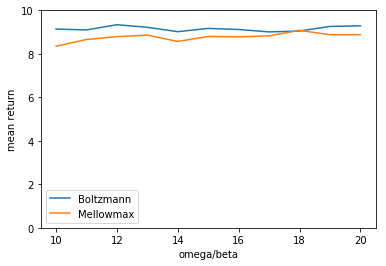

In [0]:
fig_best=plt.figure()
ax=fig_best.add_subplot(111)
plt.plot(np.arange(10,21),x_best,label='Boltzmann')
plt.plot(np.arange(10,21),y_best,label='Mellowmax')
plt.ylim(0,10)
plt.ylabel('mean return')
plt.xlabel('omega/beta')
plt.legend()
plt.savefig('taxi.png')